In [240]:
import numpy as np
import pandas as pd

# from sklearn.metrics.pairwise import cosine_similarity
import scipy
from scipy import spatial
from scipy import sparse
import time

import matplotlib.pyplot as plt


ML_DATA = '/Users/sahil/scikit_learn_data/ml-100k/'

In [8]:
rating_df = pd.read_table(ML_DATA+'u.data', names=["user_id", "movie_id", "rating", "timestamp"])
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'], unit='s')
print(rating_df.shape)
rating_df.head()

(100000, 4)


,user_id,movie_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [147]:
rating_df[(rating_df.user_id == 196) & (rating_df.movie_id == 242)].rating

0    3
Name: rating, dtype: int64

In [178]:
train_rating_df = pd.read_table(ML_DATA+'ua.base', names=["user_id", "movie_id", "rating", "timestamp"])
train_rating_df['timestamp'] = pd.to_datetime(train_rating_df['timestamp'], unit='s')
print(train_rating_df.shape)

(90570, 4)


In [200]:
train_rating_df.head()

,user_id,movie_id,rating,timestamp
0,1,1,5,1997-09-22 22:02:38
1,1,2,3,1997-10-15 05:26:11
2,1,3,4,1997-11-03 07:42:40
3,1,4,3,1997-10-15 05:25:19
4,1,5,3,1998-03-13 01:15:12


In [179]:
test_rating_df = pd.read_table(ML_DATA+'ua.test', names=["user_id", "movie_id", "rating", "timestamp"])
test_rating_df['timestamp'] = pd.to_datetime(test_rating_df['timestamp'], unit='s')
print(test_rating_df.shape)

(9430, 4)


In [9]:
col_names = [
        "movie_id", "movie_title", "release_date", "video_release_date",
        "imdb_url", "unknown", "Action", "Adventure", "Animation",
        "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
        "Film_Noir", "Horror", "Musical", "Mystery", "Romance", "Sci_Fi",
        "Thriller", "War", "Western"]
movie_df = pd.read_table(ML_DATA+'u.item', encoding="ISO-8859-1", sep='|', names=[x.lower() for x in col_names])
movie_df["release_date"] = pd.to_datetime(movie_df["release_date"])
print(movie_df.shape)
movie_df.head()

(1682, 24)


,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children's,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
user_df = pd.read_table(ML_DATA+'u.user', names=["id", "age", "gender", "occupation", "zip_code"], sep = '|')
print(user_df.shape)
user_df.head()

(943, 5)


,id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [180]:
user_movie_matrix = np.full((user_df.shape[0], movie_df.shape[0]), np.nan)
for index, row in train_rating_df.iterrows():
    user_movie_matrix[row['user_id']-1, row['movie_id']-1] = row['rating']

In [190]:
user_movie_matrix

array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

In [182]:
user_similarity = np.zeros((user_df.shape[0], user_df.shape[0]))

t = time.time()
for i in range(user_movie_matrix.shape[0]):
    for j in range(user_movie_matrix.shape[0]):
        if i == j:
            user_similarity[i,j] = 1
            continue
        ir = user_movie_matrix[i,:]
        jr = user_movie_matrix[j,:]
#         print(ir.shape, jr.shape)
#         print(np.where(~np.isnan(ir))[0], np.where(~np.isnan(jr))[0])
        _indices = np.intersect1d(np.where(~np.isnan(ir))[0], np.where(~np.isnan(jr))[0])
#         _indices = np.intersect1d(np.where(~np.isnan(ir))[0], np.where(~np.isnan(jr))[0])
        if len(_indices) == 0:
            user_similarity[i,j] = 0
#             print(f' {i}, {j} have no common movies')
            continue
        user_similarity[i,j] = 1-spatial.distance.cosine(ir[_indices], jr[_indices])
    if i%100 == 0:
        print(f'user {i} - {round(time.time()-t, 3)}')
        t = time.time()

user 0 - 0.161
user 100 - 13.78
user 200 - 13.965
user 300 - 14.642
user 400 - 13.646
user 500 - 13.562
user 600 - 13.193
user 700 - 13.046
user 800 - 12.881
user 900 - 13.737


In [109]:
np.round(user_similarity, 3)

array([[1.   , 0.961, 0.857, ..., 0.971, 0.924, 0.93 ],
       [0.961, 1.   , 0.936, ..., 0.94 , 0.948, 0.977],
       [0.857, 0.936, 1.   , ..., 0.973, 0.912, 0.99 ],
       ...,
       [0.971, 0.94 , 0.973, ..., 1.   , 0.982, 0.961],
       [0.924, 0.948, 0.912, ..., 0.982, 1.   , 0.976],
       [0.93 , 0.977, 0.99 , ..., 0.961, 0.976, 1.   ]])

In [238]:
def predict_rating(user_id, movie_id, k, sim_matrix):
    sim_user_indices = np.argsort(sim_matrix[user_id-1, :])[::-1]
    sim_user_ids = [x+1 for x in sim_user_indices if x+1 != user_id] # convert indices to id and remove same user's id
    sim_user_ratings = []
    weights = []
    _k = 0
    for u_id in sim_user_ids:
        _r = train_rating_df[(train_rating_df.user_id == u_id) & (train_rating_df.movie_id == movie_id)]
        if len(_r) == 0 or u_id == user_id:
            continue
        else:
            _k+=1
            _r = _r['rating'].values[0]
#             print(u_id, sim_matrix[u_id-1, user_id-1], _r)
            sim_user_ratings.append(_r)
            weights.append(sim_matrix[u_id-1, user_id-1])
            if _k == k:
                break
#     print(sim_user_ratings)
#     print(weights)
    return np.average(sim_user_ratings, weights=weights)

In [233]:
predict_rating(1, 20, 10, user_similarity)

[4, 3, 2, 3, 4, 2, 5, 4, 5, 4]
[0.9826588185416997, 0.9796466309866624, 0.9780059881267369, 0.9752447566981104, 0.9705957318916849, 0.9683417655698434, 0.9677450841288013, 0.9676084960616761, 0.9657031683831926, 0.9635645012921532]


3.597274168887529

In [165]:
# user_similarity[195, 117]

1.0

In [175]:
# ir = user_movie_matrix[195,:]
# jr = user_movie_matrix[117,:]

# _indices = np.intersect1d(np.where(~np.isnan(ir))[0], np.where(~np.isnan(jr))[0])
# _indices, ir[_indices], jr[_indices]

(array([654]), array([5.]), array([5.]))

In [235]:
from sklearn.metrics import mean_squared_error

In [242]:
mse = []
rmse = []
ks = list(range(1, 50, 2))
for k in ks:
    t = time.time()
    y_pred = []
    y_true = []
    for idx, vals in enumerate(test_rating_df.loc[:, ['user_id', 'movie_id']].values):
        user_id, movie_id = vals
        y_pred.append(predict_rating(user_id, movie_id, k, user_similarity))
        y_true.append(test_rating_df.loc[idx, 'rating'])
        
        if idx == 101:
            print(f'{k} {time.time()-t}')
            break
    mse.append(mean_squared_error(y_true, y_pred))
    rmse.append(np.sqrt(mse[-1]))

1 11.863110065460205
3 19.0128231048584
5 25.00176501274109
7 28.48245620727539
9 30.752810955047607
11 33.76921510696411
13 37.891305923461914
15 39.19296431541443
17 41.26323199272156
19 44.69965696334839
21 45.83637189865112
23 48.31591725349426
25 49.00671577453613
27 50.38328719139099
29 53.43999791145325
31 54.61395287513733
33 5865.579217910767
35 1088.866625070572
37 67.24568390846252
39 84.24712920188904
41 79.98179292678833
43 78.60578203201294
45 68.27002787590027
47 74.63964796066284
49 76.7568712234497


Text(0,0.5,'rmse')

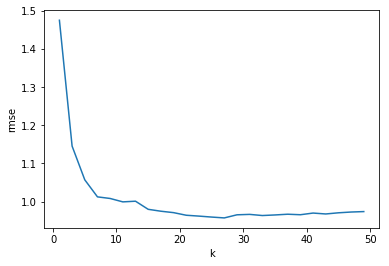

In [244]:
plt.plot(ks, rmse)
plt.xlabel('k')
plt.ylabel('rmse')